# Introduction
Traditional pairs trading strategies rely on strict assumptions about the relationships between securities, namely that there exists a linear relationship between candidate securities.

The concept of **Mutual Information** from Information Theory allows us to loosen this linear assumption and extend the asset universe selection with polynomial relationships.

The mutual information of two random variables measures the mutual dependence between two variables and is often used as a generalized version of correlation. Securities with high mutual information indicate the existence of either a linear or nonlinear relationship which can be utilized to generate a dollar neutral portfolio.

The research notebook is divided into the following sections:
<ol>
    <li>Data Collection and Cleaning </li>
    <li>Potential Pair Selection </li>
    <li>Spread Modeling</li>
    <li>Mean Reversion and Stationarity Testing</li>
    <li>Trade Signal Generation </li>
    <li>Backtest </li>
    <li>Performance Summary </li>
    <li>Conclusion </li>
</ol>

# Load Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mutual_information_pairs_functions import *

# Data Collection and Cleaning

 
We will handle this process by the following:  
1. **Importance**: Finding a set of stocks whose prices are below an upperbound price limit (contingent on the size of the account). The price limit is designed to ensure proper position sizing which is crucial when it comes to any arbitrage strategy.
2. Clean and log-transform asset prices. 

Connect to an exchange using the library `ccxt`.  
In this demonstration, Binance's *Spot Hourly-intraday* data will be used.

In [3]:
# import data
with open(r"C:\Users\Steven\Documents\mutual_info\crypto_spot_data.csv", 'r') as f:
    prices = pd.read_csv(f)
prices.set_index('timestamp', inplace=True)

In [2]:
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
_ = load_dotenv(find_dotenv())
binance_api_key = os.getenv('BINANCE_API_KEY')
binance_api_secret = os.getenv('BINANCE_API_KEY')
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)
ex = choose_exchange()

# look for Binance's Spot assets whose prices < 300 USD
symbols = get_crypto_tickers(market_type='spot', exchange=ex, price_limit=300, quote_curr="USDT")
# get maximum number of Hourly historical bars
prices = crypto_historical_data(get_all_binance, symbols, '1h')

# save downloaded data to .csv file
with open(r"C:\Users\Steven\Documents\mutual_info\crypto_spot_data.csv", 'w') as f:
    prices.to_csv(f)
log_prices = preprocess_data(prices)
print(log_prices.shape)

securities = log_prices.columns
n_securities = len(securities)
log_prices.head()


Number of CRYPTO symbols: 118
(14974, 118)


,TRXUSDT,SOLUSDT,TOMOUSDT,LRCUSDT,DOGEUSDT,NEOUSDT,MANAUSDT,LTCUSDT,COMPUSDT,VETUSDT,...,STMXUSDT,CELRUSDT,NEARUSDT,1INCHUSDT,ALICEUSDT,XRPUSDT,ICXUSDT,LITUSDT,CHRUSDT,NKNUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-03-29 11:00:00,-2.731984,2.911252,0.975314,-0.623752,-2.914252,3.825768,0.084984,5.273768,5.934577,-2.391558,...,-2.871764,-2.393714,1.753798,1.460079,2.783893,-0.576556,0.866134,2.291787,-0.925710,-1.715521
2021-03-29 12:00:00,-2.732292,2.915752,0.969528,-0.608053,-2.910344,3.822951,0.082998,5.276123,5.936982,-2.379110,...,-2.869910,-2.394810,1.759064,1.461564,2.810420,-0.577304,0.865292,2.315669,-0.913245,-1.692765
2021-03-29 13:00:00,-2.728610,2.919396,0.965310,-0.612895,-2.916538,3.822711,0.098016,5.267549,5.937404,-2.378592,...,-2.853365,-2.386837,1.770434,1.479807,2.797958,-0.582035,0.860778,2.292636,-0.912847,-1.698980
2021-03-29 14:00:00,-2.734446,2.916532,0.962640,-0.605411,-2.917112,3.822536,0.080796,5.269043,5.940750,-2.384674,...,-2.839071,-2.375909,1.764028,1.478760,2.775728,-0.583253,0.873425,2.277277,-0.913844,-1.699363
2021-03-29 15:00:00,-2.737685,2.898604,0.950499,-0.623658,-2.918475,3.813020,0.069237,5.265691,5.932245,-2.385890,...,-2.864599,-2.412735,1.745890,1.473206,2.774462,-0.587581,0.860228,2.276159,-0.873543,-1.714798


# Potential Pair Selection

The mutual information of the pair is defined as: 

$\begin{aligned}I[X,Y] = H[X] - H[X|Y] &= H[X] + H[Y] - H[X, Y] \\ 
       &= \displaystyle\sum_{x \in S_x}\displaystyle\sum_{y \in S_y}p[x,y]\log\big[\frac{p[x,y]}{p[x]p[y]}\big]\end{aligned}$ 

  Where $p[x,y]$ is the probability mass function of $X$ and $Y$.

  $p[x]$ and $p[y]$ are the marginal probability density functions of $X$ and $Y$ respectiely.

Pairs with a mutual information score above an arbitrary cutoff are selected. In this example, securities in the top decile are selected.

In [3]:
pairs = list(combinations(securities, 2))
pairs_list = []
for pair in pairs:
    pairs_list.append(convertTuple(pair))
pairs_list[:5] # Print example

['CFXUSDT-IOSTUSDT',
 'CFXUSDT-LITUSDT',
 'CFXUSDT-RENUSDT',
 'CFXUSDT-COCOSUSDT',
 'CFXUSDT-DUSKUSDT']

In [3]:
try:
    mutual_info_df = pd.read_csv(f'crypto_mutual_info_{n_securities}.csv', index_col=0)
    print('mutual_info_df loaded')
except FileNotFoundError:
    print('Calculating mutual_info_df')
    mutual_info_df = calculate_mutual_information(pairs, pairs_list, log_prices)
    mutual_info_df.to_csv(f'crypto_mutual_info_{n_securities}.csv')

mutual_info_df loaded


### Plot Mutual Information Scores

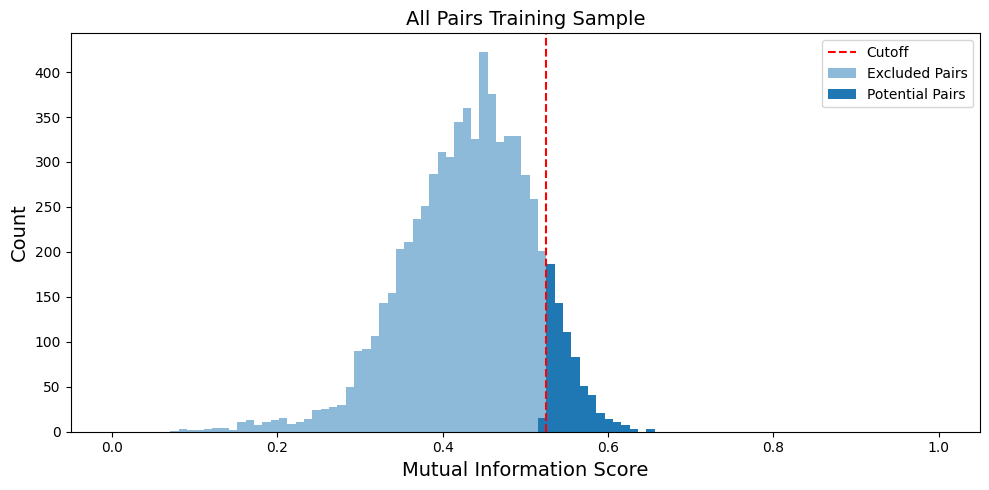

In [4]:
top_quantile = mutual_info_df.quantile(0.9)
potential_pairs = mutual_info_df[mutual_info_df >= top_quantile].dropna()
plot_potential_pairs_hist(mutual_info_df, potential_pairs)

# Spread Modeling
To estimate the relationship between the potential pairs, polynomial regression is conducted. For each potential pair, a grid search over five degrees is performed by regressing the price pairs. To avoid overfitting the model, the polynomial regression that has the lowest mean squared error across a five-fold cross validation is chosen.  
From the bar chart below, the majority of the estimated relationships are linear while the remaining are nonlinear. This indicates that while a linear relationship is a valid assumption for certain pairs, the assumption does not capture certain relationships between securities in the market. The polynomial regression allows the strategy to more accurately model the spread relationships between potential pairs. 

In [8]:
try:
    cv_models = pd.read_csv(f'crypto_cv_models_{n_securities}.csv', index_col=0)
    cv_predicted = pd.read_csv(f'crypto_cv_models_cv_predicted_{n_securities}.csv', index_col=0)
    cv_spreads_train = pd.read_csv(f'crypto_cv_spreads_train_{n_securities}.csv', index_col=0)
    
    print('cv_models loaded')
    print('cv_predicted loaded')
    print('cv_spreads_train loaded')
except FileNotFoundError:
    print('Generating cross-validated dataframes')
    potential_pairs_tuples = []
    for pair in potential_pairs.index:
        potential_pairs_tuples.append(convertString(pair))

    cv_predicted, cv_models, cv_spreads_train = generate_cv_dataframes(potential_pairs_tuples, log_prices)

Generating cross-validated dataframes
(14974, 691)


### Plot Polynomial Models

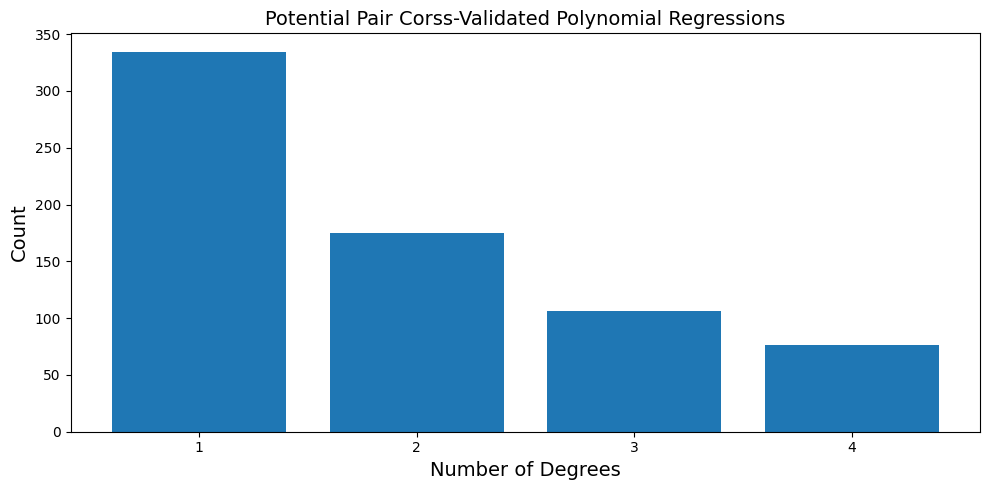

In [8]:
plot_cv_model_degrees(cv_models)

# Mean Reversion and Stationarity Testing
Pairs trading strategies profit when the modeled spreads revert to the mean. In this section, the modeled spreads are tested rigorously for mean reversion and stationarity properties. A mean reverting spread creates profitable trading opportunities by entering long positions in the underperforming security and short positions in the outperforming security. 

### Two Mean Reversion statistics:  
1. The **Hurst exponent**, H, is used to measure the long-term memory of a time series. A value in the range of [0-0.5) indicates that a time series reverts strongly to the mean while a value of [0.5-1] indicates a time series with long-term positive autocorrelation and is likely to diverge. The Hurst exponent is calculated as: 
$\begin{aligned} \mathbb{E}\big[\frac{R(n)}{S(n)}\big] = Cn^H , n \rightarrow \infty\end{aligned}$ $R(n)$ is the range of the first $n$ cumulative deviations from the mean.  
$S(n)$ is the series of the first $n$ standard deviations.  
$\mathbb{E}$ is the expected value.  
$n$ is the number of observations in the time series.  
$C$ is a constant.    
  
2. The **Half-Life** of a series is the amount of time it takes for a series to return to half its initial value and is defined as: 
$\begin{aligned} N(t) = N_0e^{-\lambda t} \end{aligned}$
$N_0$ is the initial quantity of the spread that will decay.  
$N(t)$ is the quantity that still remains and has not yet decayed after a time $t$.  
$\lambda$ is a positive number called the decay constant.  
The half-life, $t_{1/2}$ is defined as:
$\begin{aligned} t_{1/2} = \frac{ln(2)}{\lambda} \end{aligned}$  
Spreads with short half-lives indicate portfolios that revert to the mean often and create many trading opportunities.




In [9]:
hurst_exponents = []
for col in potential_pairs.index:
    hurst_exp = calc_hurst(cv_spreads_train[col].values)
    hurst_exponents.append(hurst_exp)
    
half_lives = cv_spreads_train[potential_pairs.index].apply(calc_half_life)

cv_hurst_exponents = pd.DataFrame({'hurst_exponent':hurst_exponents}, index=potential_pairs.index)
cv_half_lives = pd.DataFrame({'half_life':half_lives}, index=potential_pairs.index)

### Stationarity Test Statistics  
Four stationarity tests are calculated for the modeled spreads:

<ul>
    <li>Augmented Dickey–Fuller: Null hypothesis that a unit root is present in the time series   </li>
    <li>Kwiatkowski–Phillips–Schmidt–Shin: Null hypothesis that the time series is stationary   </li>
    <li>Phillips–Perron: Null hypothesis that a time series is integrated of order 1   </li>
    <li>Lo-Mackinlay Variance Ratio: Null hypothesis that spread follows a random walk   </li>
</ul>
Spreads that reject the Augmented Dickey–Fuller, Phillips–Perron, and Lo-Mackinlay tests indicate that a series is likely stationary. On the other hand, spreads that fail to reject the Kwiatkowski–Phillips–Schmidt–Shin test indicate a series is likely stationary.

In [10]:
cv_stationary_tests = generate_stationarity_dataframe(potential_pairs.index, cv_spreads_train)
cv_test_stats = pd.concat([cv_half_lives, cv_hurst_exponents, cv_stationary_tests], axis=1)
cv_test_stats.describe()

,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
count,691.000000,691.000000,691.000000,6.910000e+02,691.000000,691.000000,691.000000,6.910000e+02,691.000000,6.910000e+02
mean,392.657795,0.445753,-3.731509,6.693500e-02,2.344813,0.016383,-3.927195,5.818138e-02,-2.524209,1.148377e-01
std,1124.248891,0.032461,1.212076,1.548830e-01,2.152660,0.018792,1.283615,1.471475e-01,1.373903,2.123348e-01
min,-23281.761806,0.329078,-8.388662,2.399665e-13,0.207817,0.010000,-8.273466,4.724708e-13,-7.248705,4.207745e-13
25%,192.747650,0.426142,-4.516042,1.839253e-04,0.864921,0.010000,-4.740521,7.060822e-05,-3.491392,4.805386e-04
50%,273.334317,0.447719,-3.772842,3.197728e-03,1.592294,0.010000,-3.994505,1.439562e-03,-2.350418,1.875233e-02
75%,452.916827,0.467211,-2.896791,4.574153e-02,3.090218,0.010000,-3.046379,3.078436e-02,-1.621861,1.048355e-01
max,10617.391148,0.560285,0.466545,9.838200e-01,12.629909,0.100000,0.442888,9.830299e-01,1.398692,9.962299e-01


## Filter Potential Pairs  
To select spreads with desirable characteristics, the potential pairs are filtered further based on their mean reverting and stationarity statistics. Spreads with $H < 0.5$ and $1 \leq t_{1/2} \leq 252$ indicate mean reverting pairs with many tradable opportunities.

Additionally, spreads that reject the Augmented Dickey–Fuller, Phillips–Perron, and Lo-Mackinlay tests at the $\alpha = 0.05$ level and fail to reject the Kwiatkowski–Phillips–Schmidt–Shin test at the $\alpha = 0.05$ level are considered stationary.

In [11]:
alpha_value = 0.05
mean_reversion_value = 0.5
min_half_life = 1.0
max_half_life = 252.0
cv_filtered = cv_test_stats[(cv_test_stats['kpss_p_value'] >= alpha_value) &
                            (cv_test_stats['adf_p_value'] < alpha_value) &
                            (cv_test_stats['pp_p_value'] < alpha_value) &
                            (cv_test_stats['vr_p_value'] < alpha_value) &
                            ((cv_test_stats['half_life'] >= min_half_life) & 
                            (cv_test_stats['half_life'] <= max_half_life )) &
                            (cv_test_stats['hurst_exponent'] < mean_reversion_value)]
filtered_pairs = cv_filtered.index
cv_filtered.describe()

,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
count,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,2.500000e+01,25.000000,2.500000e+01
mean,142.496281,0.440507,-5.435518,1.103535e-04,0.371857,0.081821,-5.734848,7.862764e-05,-3.679592,6.100324e-03
std,49.536699,0.026004,0.759812,2.384206e-04,0.066736,0.016966,0.885826,2.521401e-04,1.172376,9.922080e-03
min,73.730220,0.395944,-6.501133,1.161100e-08,0.207817,0.051685,-7.371312,8.956656e-11,-6.385666,1.706535e-10
25%,109.708002,0.421614,-6.089246,1.046127e-07,0.334353,0.066790,-6.155039,7.403634e-08,-4.341494,1.415171e-05
50%,130.350203,0.440433,-5.588705,1.344414e-06,0.389517,0.081674,-5.793277,4.816669e-07,-3.727531,1.933648e-04
75%,165.594164,0.461353,-4.844706,4.463009e-05,0.424046,0.100000,-5.208282,8.456150e-06,-2.561376,1.042586e-02
max,246.552183,0.477905,-4.149306,8.019077e-04,0.459090,0.100000,-4.040312,1.213529e-03,-2.140334,3.232775e-02


### Plot Filtered Pairs

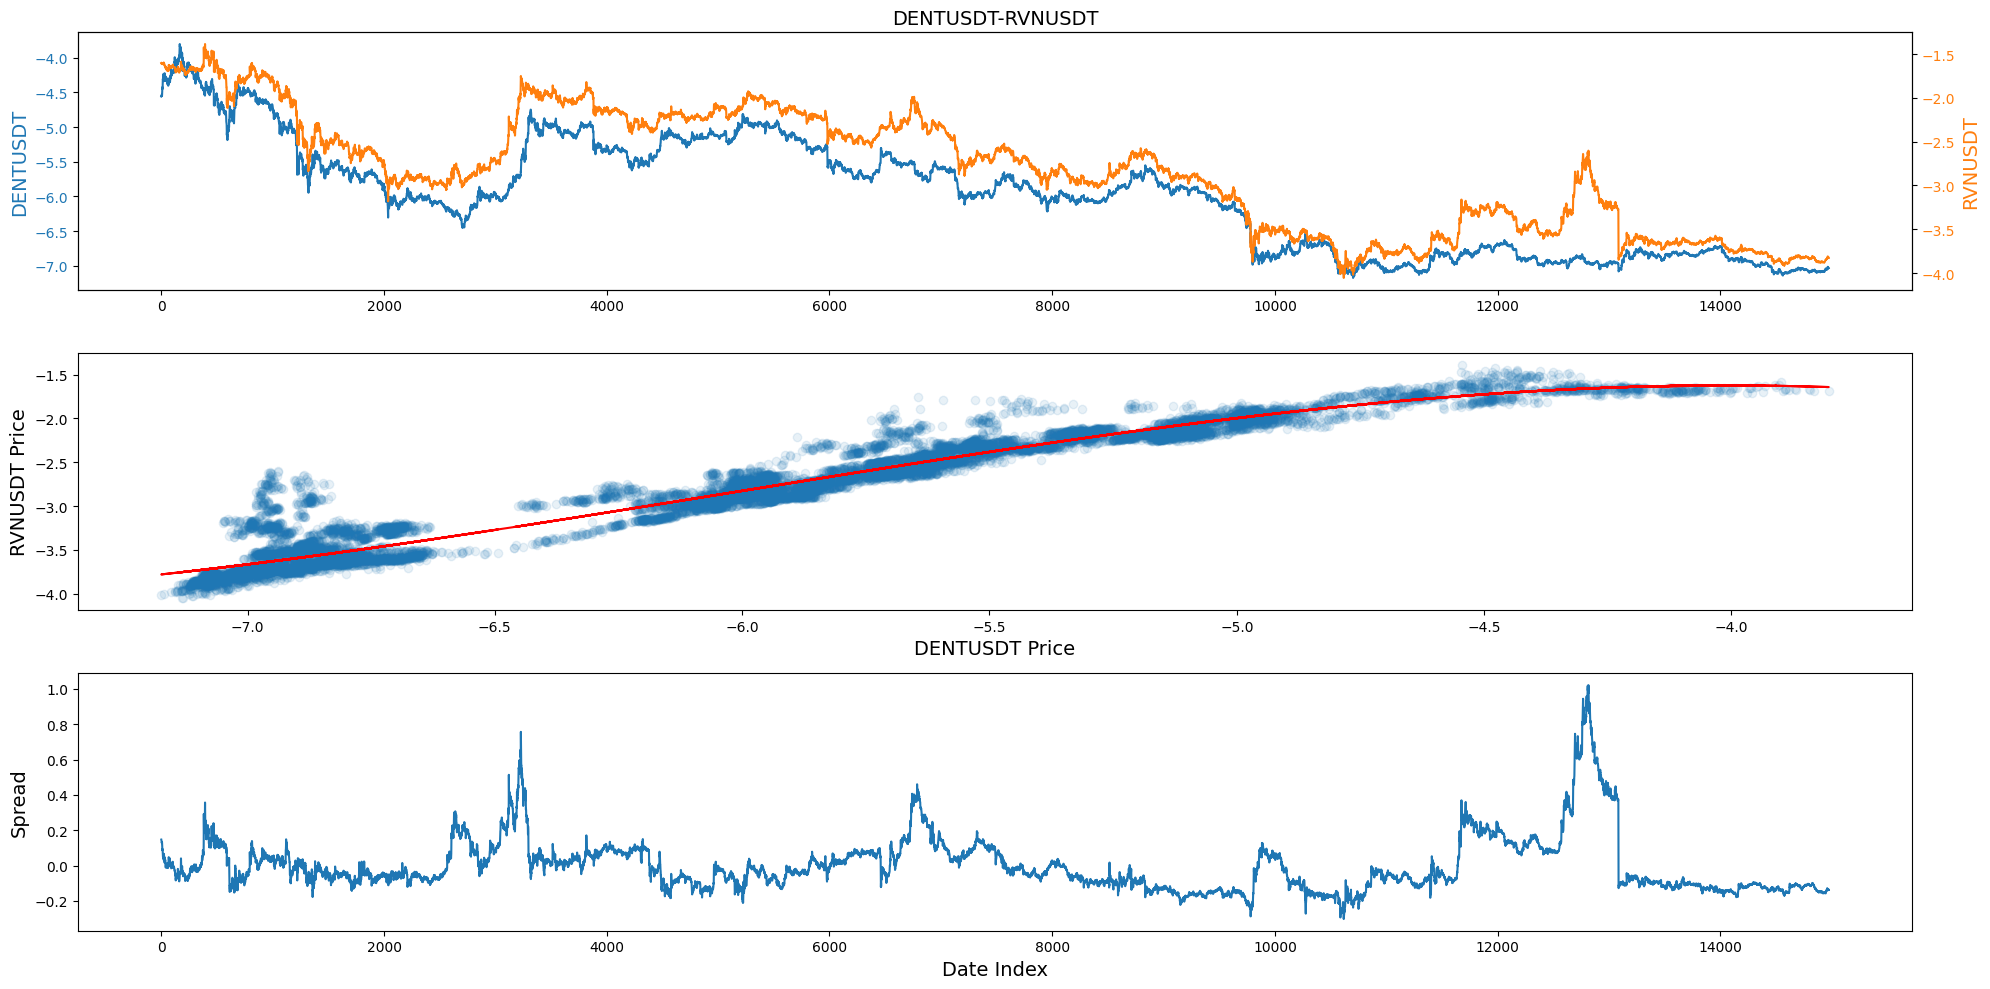

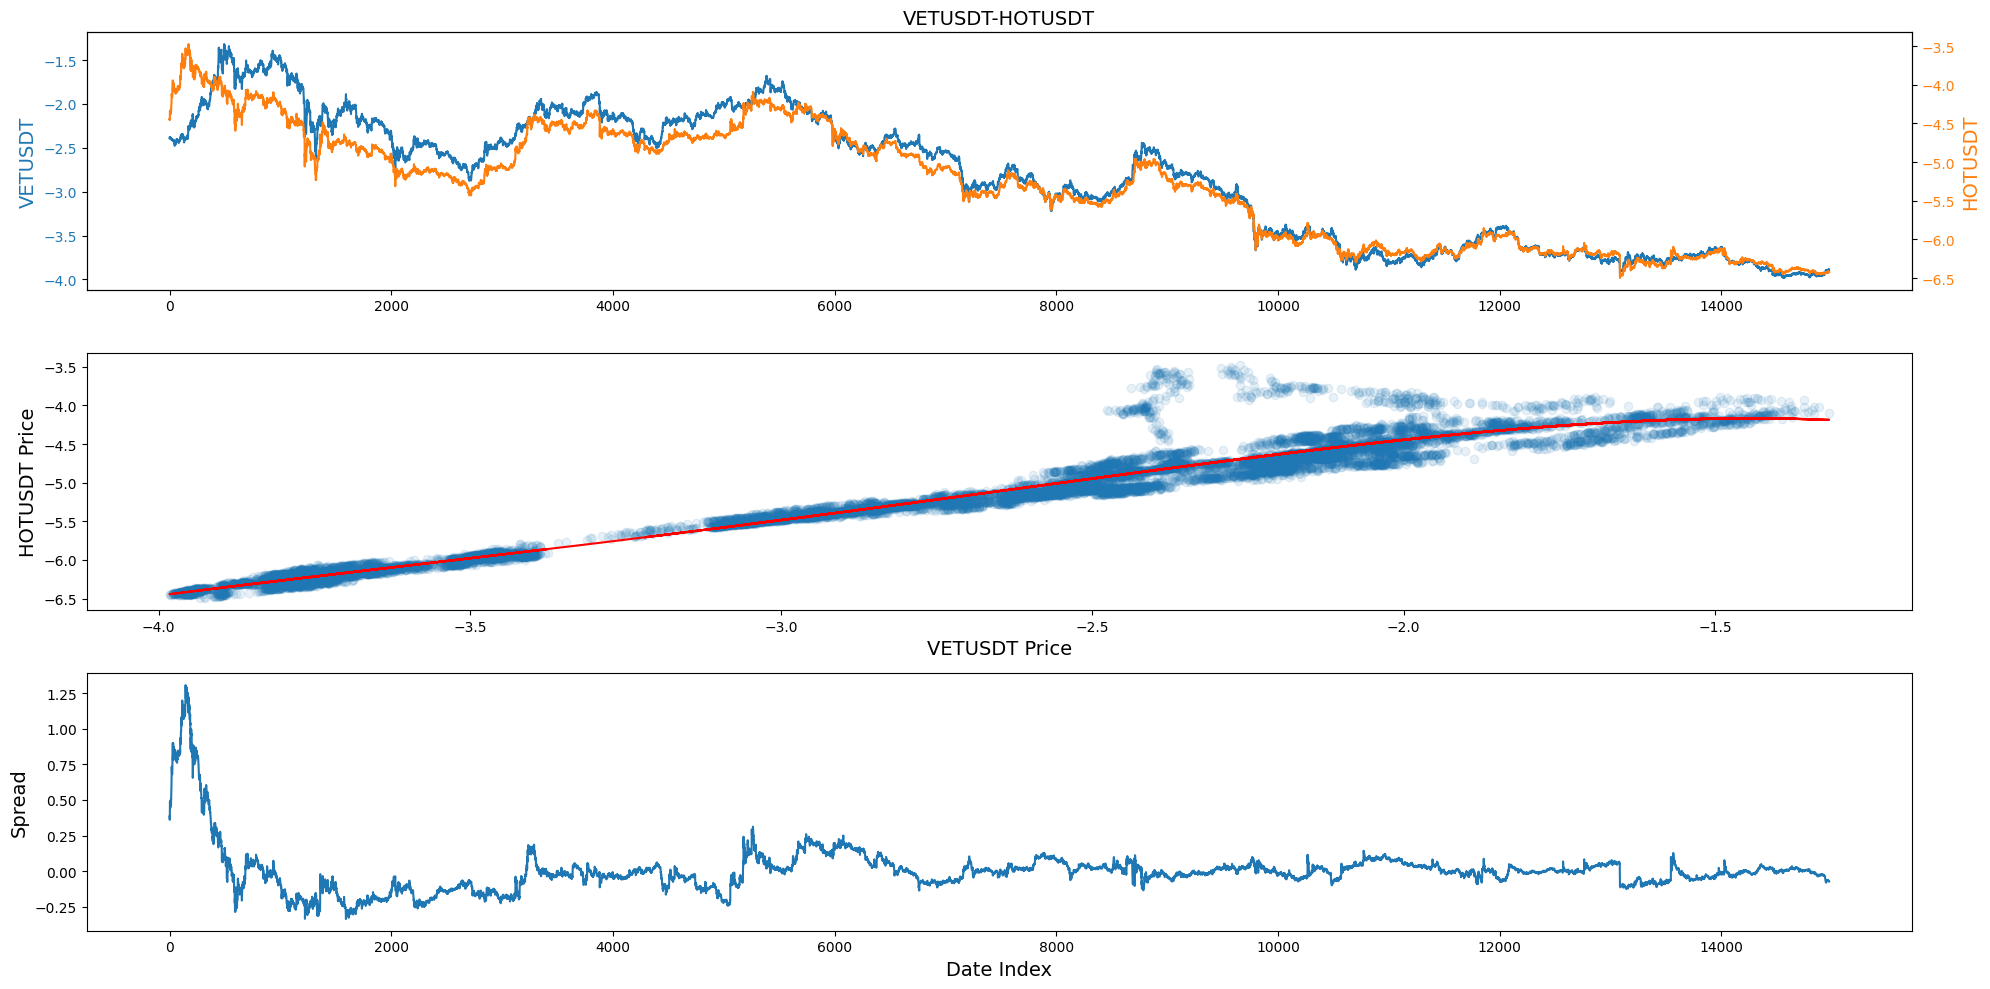

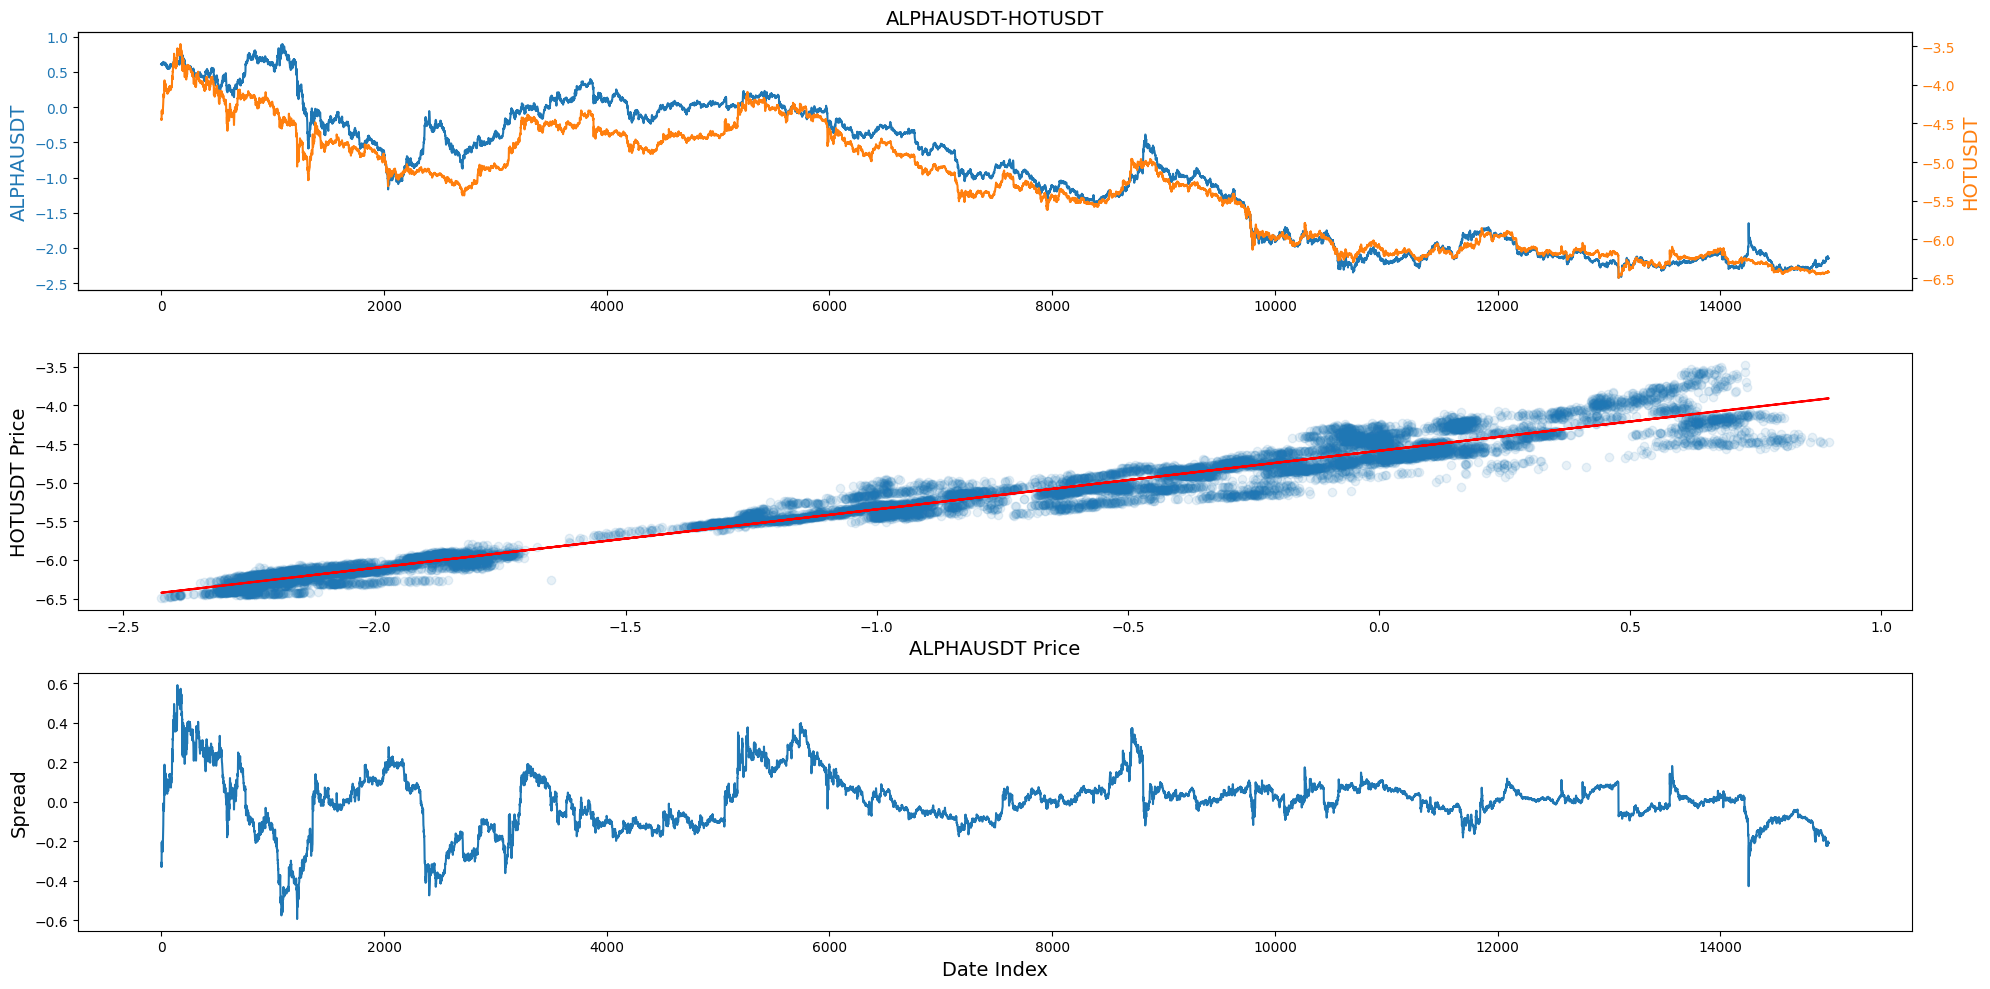

In [12]:
plot_spreads(cv_filtered.index[:3], cv_predicted, cv_spreads_train, log_prices)

# Trade Signal Generation  

Assume the spread follows an AR(1) process, we can model the spread via the volatility model GARCH(1,1).      
The GARCH(1,1) model can capture the time-varying volatility and volatility clustering (Heteroscedasticity) that are present in the spread while also nicely provides us the boundary levels from which trading rules and signals can be derived. 

**Lookahead Bias** Warning:   
 We must iterate and re-fit the GARCH model to the spread per each trading interval, as opposed to using the entire spread as this would cause the GARCH model to fit to the data that it would NOT have seen in realtime trading and thus renders the backtest unrealistic.

### Trade Logic:
A trade (of 2 opposite-side positions) is opened when the spread *crosses below* the upper-boundary from above (or *crosses above* the lower-boundary from below), and we clear the positions when the spread crosses the mean.  
This strategy significantly decreases the risk and drawdown of the portfolio as it eliminates the scenarios of substantial losses where the spread significantly or completely diverges from its estimated mean.  
Also, with the advantages of modeling the spread as a GARCH process, the estimated boundary levels are very quickly adjusted to the dynamics of the spread, thus allows for large-profit opportunities where there are great dispersions from the mean. 

### Example:
Lets simulate a stationary AR(1) process: $Xt ​= ϕXt − 1 ​+ ϵt$ and fit a GARCH(1,1) at each time $t$.

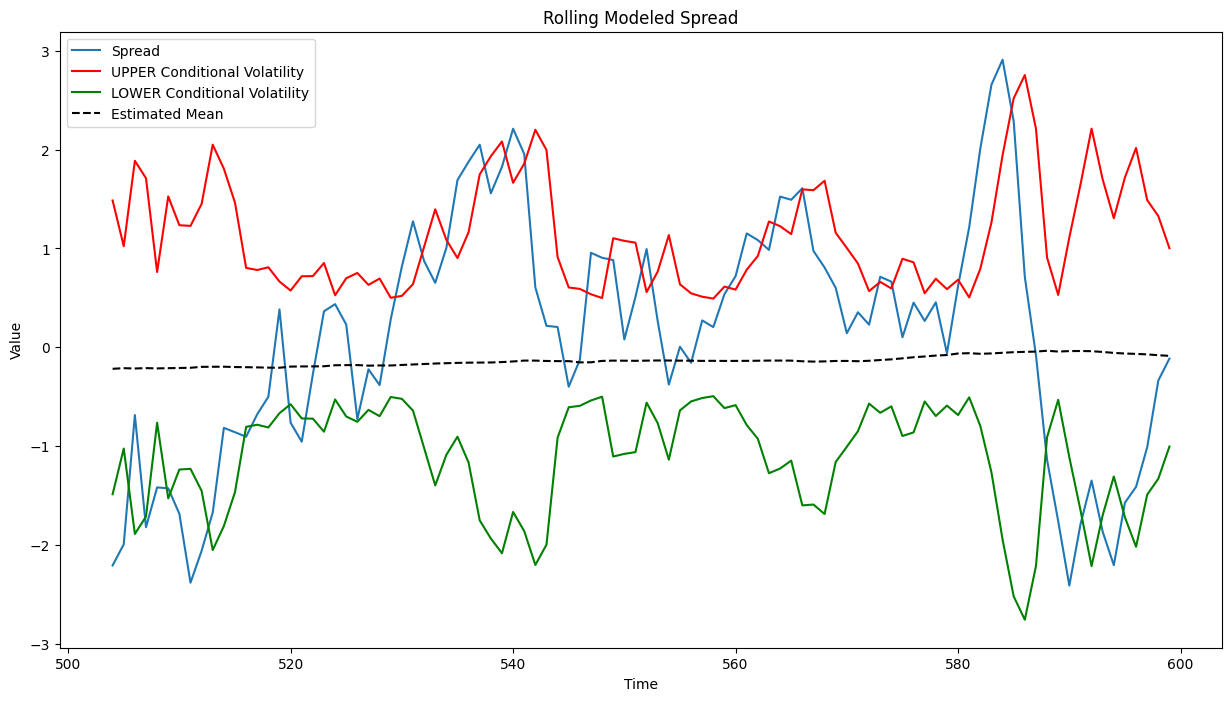

In [ ]:
# Set parameters
n = 600 # number of observations
phi = 0.9 # autoregressive coefficient
mu = 0 # mean of error term
sigma = 0.5 # standard deviation of error term
x0 = 0 # initial value of time series

# Generate error term
epsilon = np.random.normal(mu, sigma, n)

# Initialize time series
x = pd.Series(np.zeros(n))

# Set initial value
x[0] = x0

# Set training window 
window = 252 * 2 

# Generate the time series & fit GARCH model
vols = np.array([])
mean = []
for i in range(1, n):
    x[i] = phi * x[i-1] + epsilon[i]
    # fit the GARCH(1,1) model to the rolling time series
    if i >= window:
        model = arch_model(x[i-window:i], rescale=False)
        model.distribution = StudentsT(seed=42)
        model.mean = HARX(x[i-window:i][1:].values, x[i-window:i][:-1].values.reshape(-1, 1), lags=1)
        fitted_model = model.fit(disp=False)
        con_vol = fitted_model.conditional_volatility.iloc[-1]
        mu = fitted_model.params.mu
        vols = np.append(vols, con_vol)
        mean.append(mu)

# Plot 
idx = x[window:].index
plt.figure(figsize=(15, 8))
plt.plot(x[window:], label='Spread')
plt.plot(idx,vols, color='red', label='UPPER Conditional Volatility')
plt.plot(idx,-vols, color='green', label='LOWER Conditional Volatility')
plt.plot(idx, mean, color='black', label='Estimated Mean', linestyle='--')
plt.legend()
plt.title('Rolling Modeled Spread')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()



# Backtest  
The formation period which best mutual information pairs are selected is 3 weeks.  
The trading period is carried out in the next 3 days.  
To make the backtest more realistic, trading costs of 0.25% per entry or 0.5% per trade is added.  
**1:20 Leverage** is proposed in this strategy.

In [ ]:
train_window = 504 # 3 weeks
trade_window = 72 # 3 days 
backtest_result = {}
for i in range(train_window, len(prices)-trade_window, trade_window):
    train = prices.iloc[i-train_window:i]
    test = prices.iloc[i:i+trade_window+1]
    # Select the top 90 percentile during the training formation
    best_pairs, best_models = formation_crypto(train, top_pctile=0.9, use_num=False)
    if len(best_pairs) > 0 and len(best_models) > 0 and len(best_pairs) == len(best_models):
        for pair, model in zip(best_pairs, best_models):
            log_train = preprocess_data(train)
            train_spread = calc_norm_spread(pair, model, log_train)
            log_test = preprocess_data(test)
            test_spread = calc_norm_spread(pair, model, log_test)
            S1 = test[pair[0]]
            S2 = test[pair[1]]
            result = backtest_crypto(S1, S2, train_spread, test_spread, fee=0.0025) # trading cost: 0.5%
            # append backtest results
            pair_name = f'{pair[0]}-{pair[1]}'
            if pair_name not in backtest_result.keys():
                backtest_result[pair_name] = []
            backtest_result[pair_name].append(result)


In [12]:
# save backtest_result
import pickle
with open('crypto_backtest_result.pickle', 'wb') as handle:
    pickle.dump(backtest_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

### PnL of the first 3 pairs

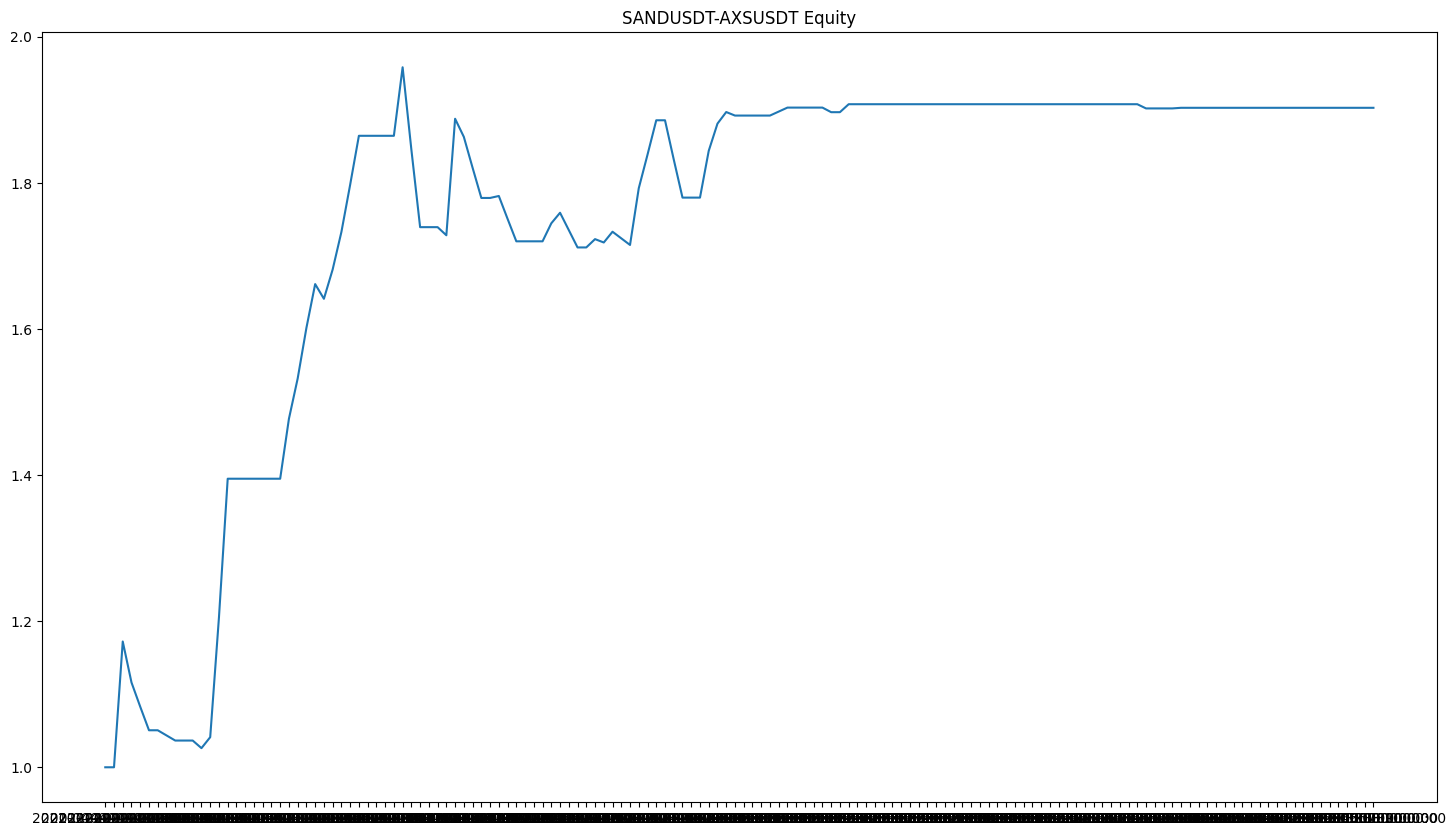

Total-Ret: 0.9029641041229763, Annual-Ret: 2.0360216533486675, Sharpe: 2.6646209586633702, 
maxDD: -0.12595738272674373, MaxDD-Duration: 111.0


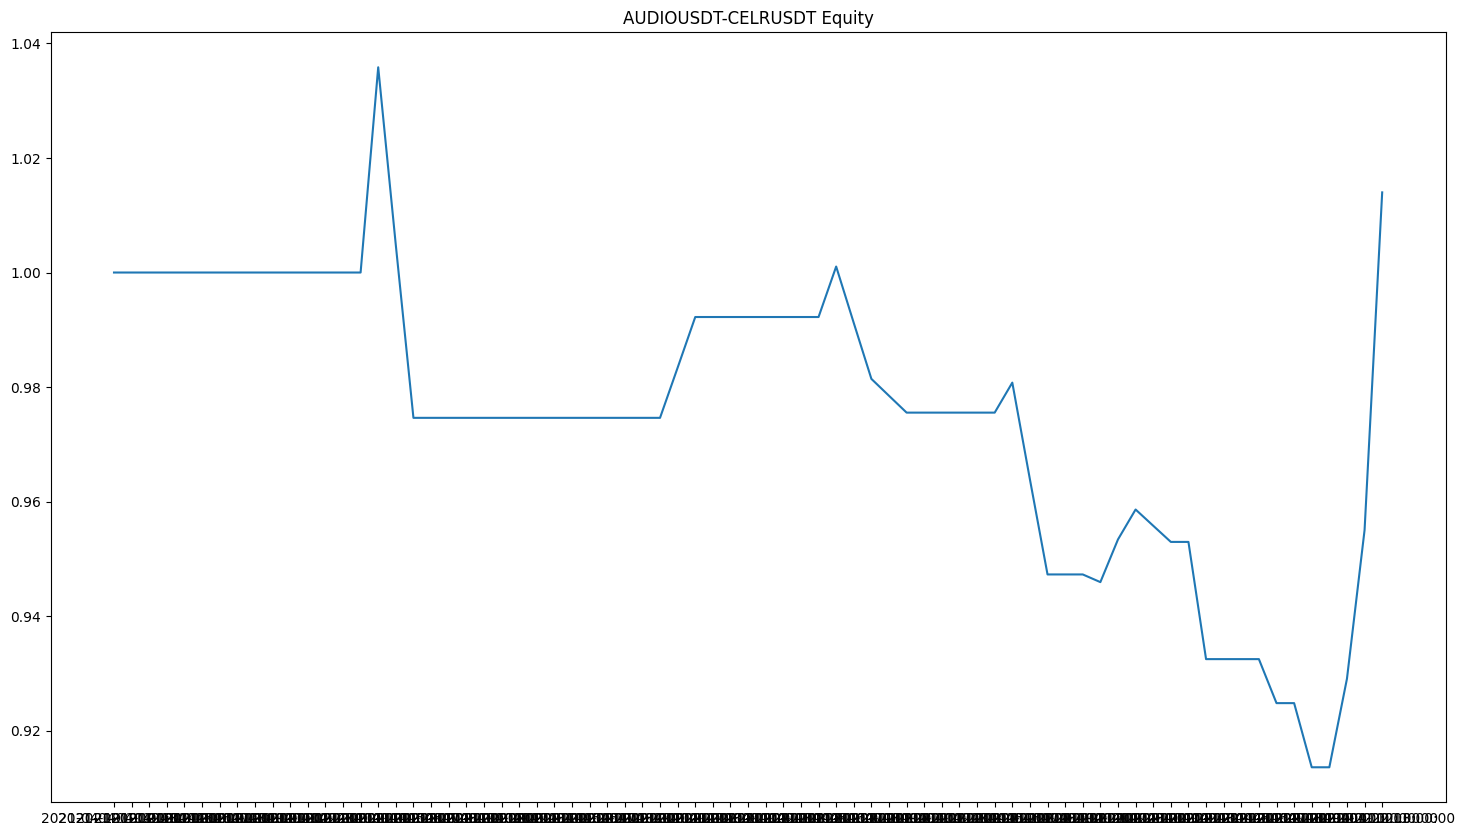

Total-Ret: 0.01399435192354459, Annual-Ret: 0.04914375715713226, Sharpe: 0.35373049573986226, 
maxDD: -0.11799959406845617, MaxDD-Duration: 57.0


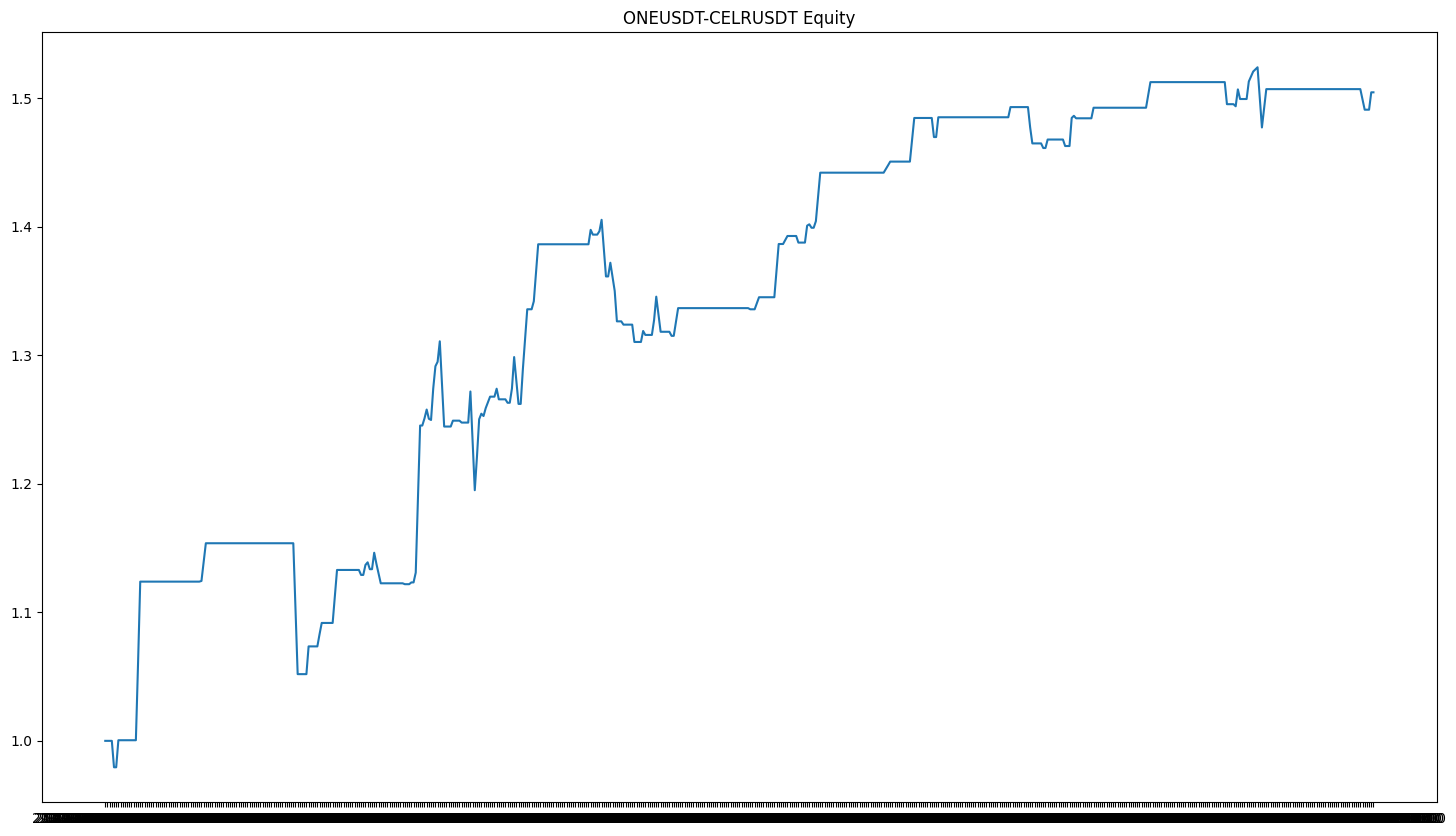

Total-Ret: 0.5043839697318966, Annual-Ret: 0.19378650122463492, Sharpe: 1.5669176405478817, 
maxDD: -0.08835286135074072, MaxDD-Duration: 98.0


In [6]:
for _, key in enumerate(list(backtest_result.keys())[:3]):
    df = pd.concat(backtest_result[key], join='inner')
    # remove duplicate
    df = df[~df.index.duplicated()]
    # calculate cumulative return
    cumret = np.nancumprod(1 + df)
    # plot
    plt.figure(figsize=(18, 10))
    plt.plot(df.index, cumret)
    plt.title(f"{key} Equity")
    plt.show()
    # calculate metrics
    total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
    print(f"Total-Ret: {total_return}, Annual-Ret: {apr}, Sharpe: {sharpe}, \n"
          f"maxDD: {maxDD}, MaxDD-Duration: {maxDDD}")
    

# Performance Summary
The Mutual Information strategy under 20x leverage significantly out-performed in all metrics when compared to the Bitcoin. During the trading period from End of March, 2021 to beginning og October, 2023, Bitcoin's ROI was -49% while the MI strategy was 285%. Max Drawdowns of Bitcoin and the MI strategy was respectively -0.77% versus -16%.  

However, The number of trades was quite small due to:  
 1. The length of backtest historical data.
 2. The strictness of the strategy's asset selection criteria. Further experiments can try to loosen some of the the criteria such as the number of Stationary tests and Mean Reverting statistics to increase the number of trading pairs.

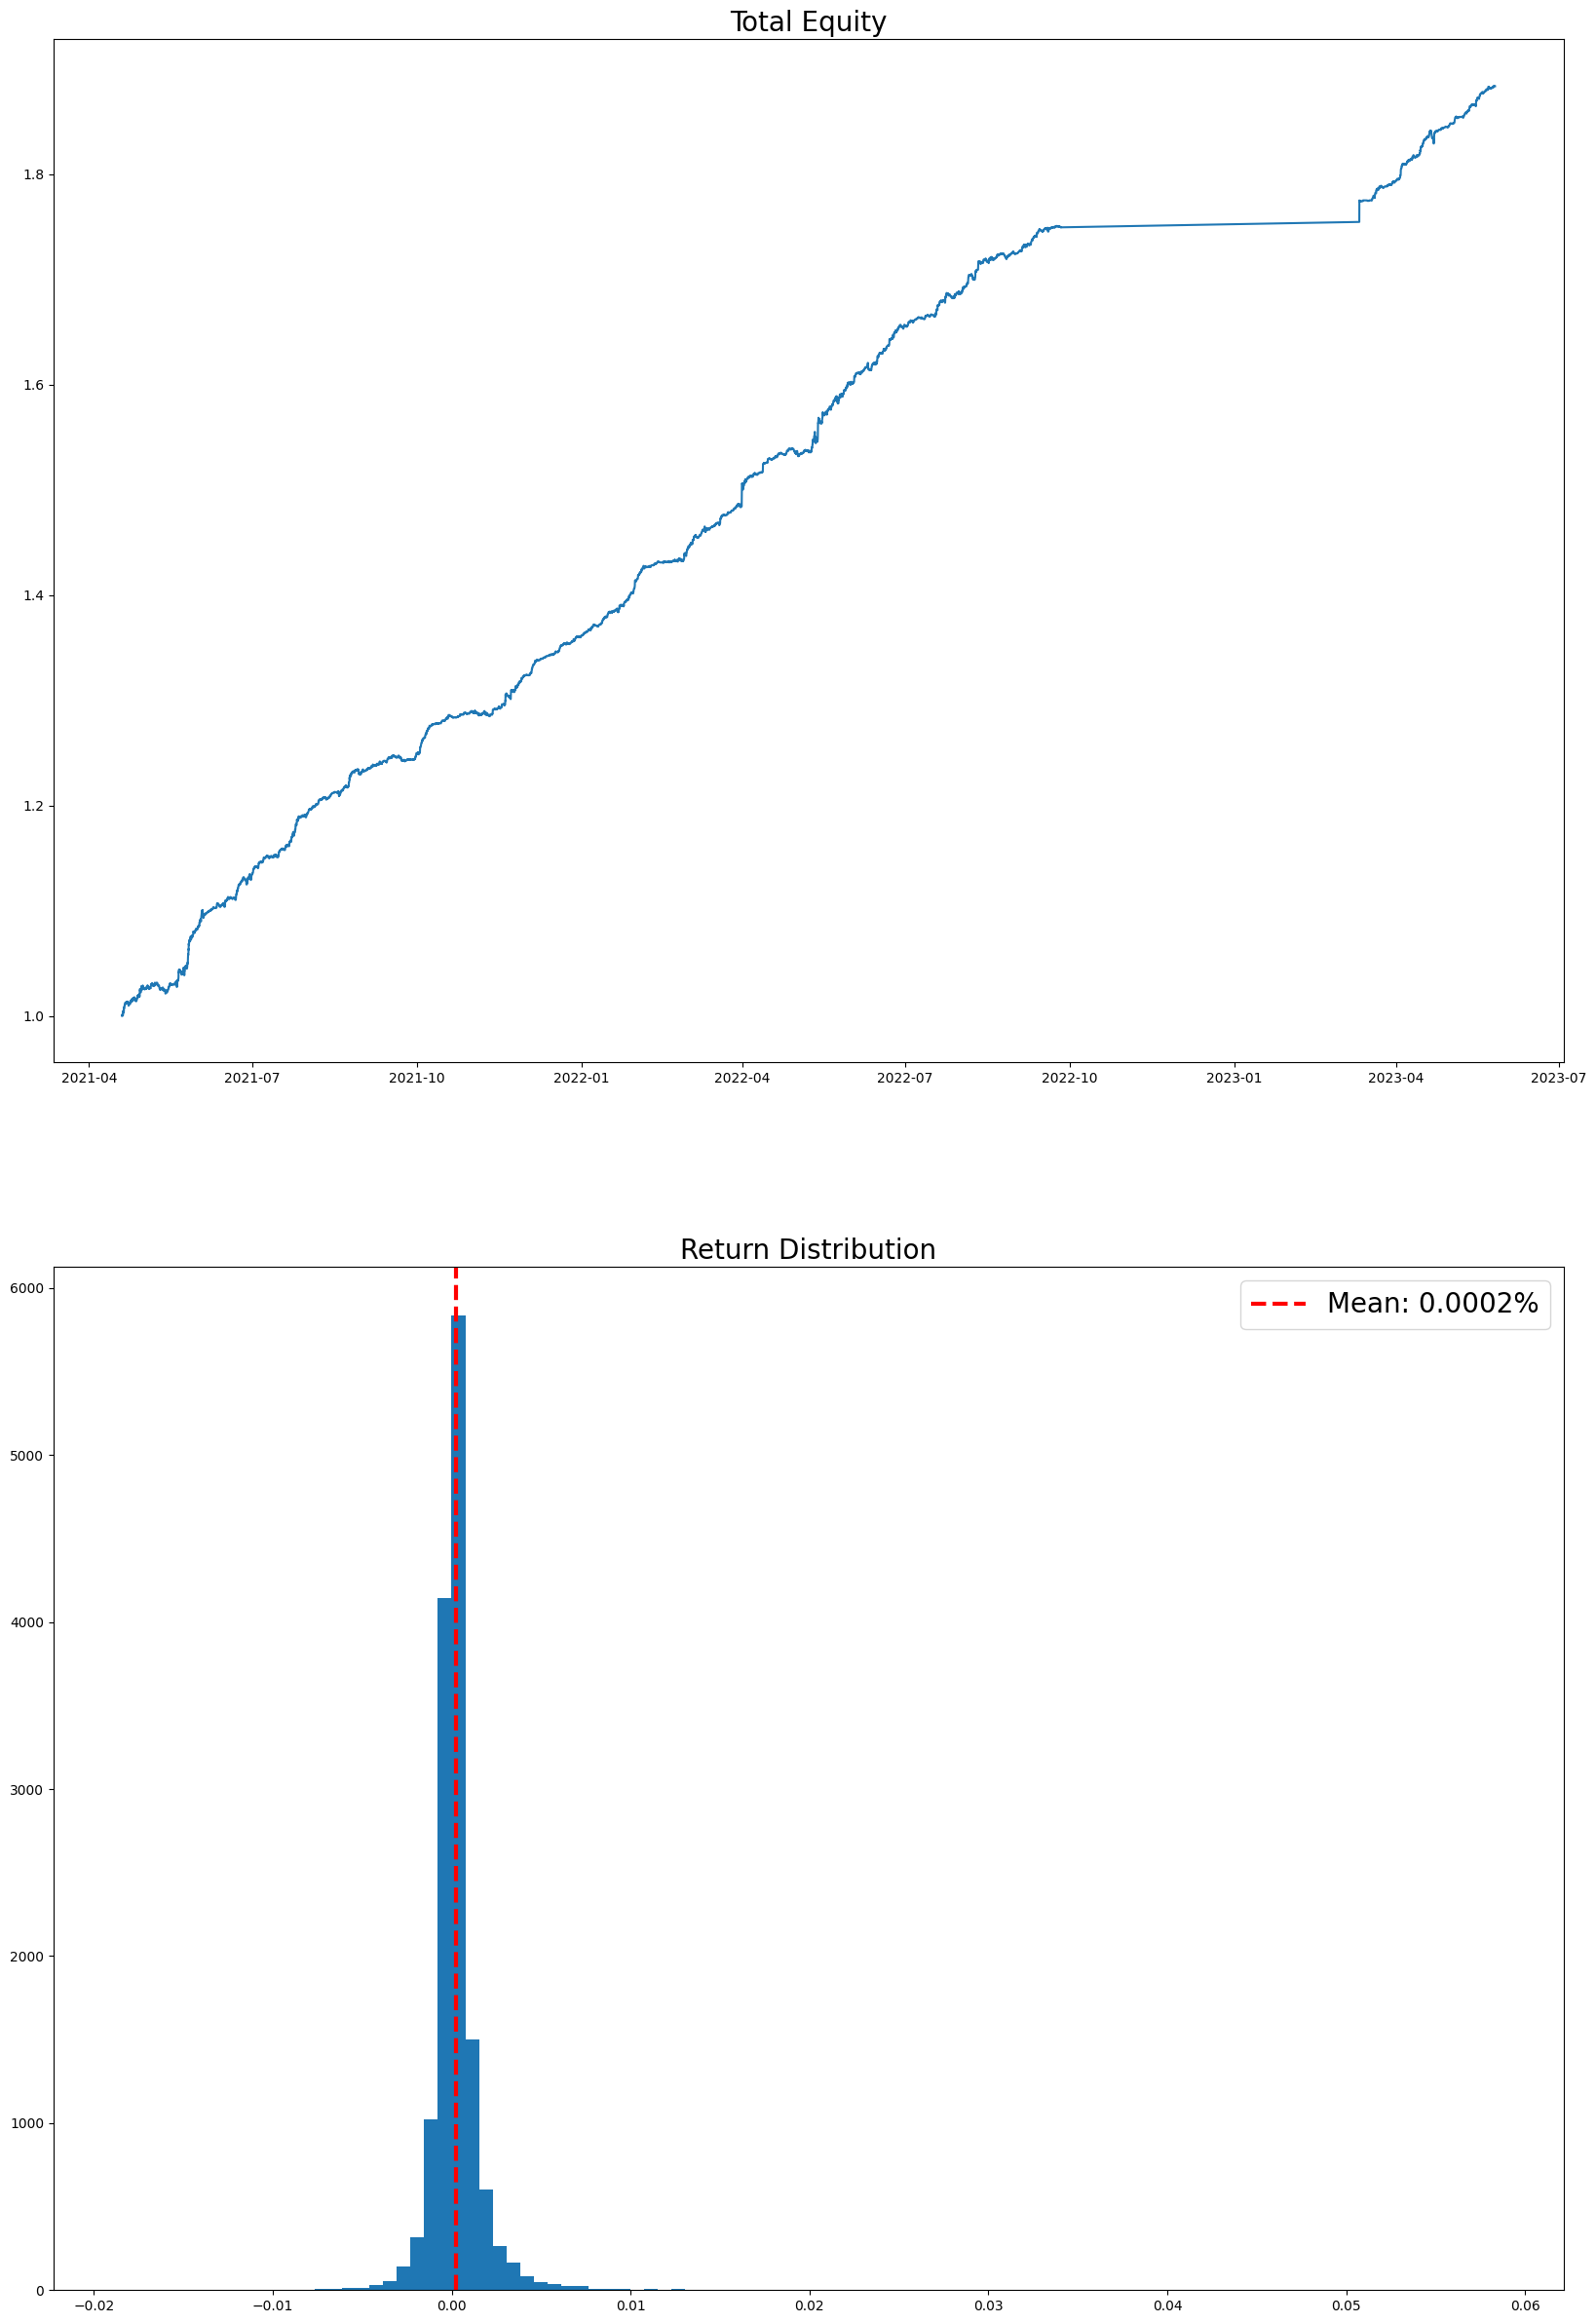

In [9]:
temp_equity = {}
for i in backtest_result.keys():
    backtest_result[i] = pd.concat(backtest_result[i])
    backtest_result[i] = backtest_result[i][~backtest_result[i].index.duplicated()]
    # remove euity[i] with all nan values
    if backtest_result[i].isnull().all():
        continue
    else:
        temp_equity[i] = backtest_result[i]
    
    
# concat all pd.Sereis in temp_equity, column-wise
df = pd.concat(temp_equity, axis=1)
df.columns = [key for key in temp_equity.keys()]
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)
df = df.sort_index()

num_pairs = len(df.columns)
# sum up the daily returns across all columns
df['total'] = df.sum(axis=1) / num_pairs
# calculate the cumulative returns
cumret_main = np.nancumprod((df['total'] * 20) + 1) # 20 Leverage
expected_ret = df['total'].mean()
# plot the total equity curve
fig, ax = plt.subplots(2, 1, figsize=(20, 30))
ax[0].plot(df.index, cumret_main)
ax[0].set_title(f"Total Equity", fontsize=20)
# plot the histogram of the  pd series
ax[1].hist(df['total']*100, bins=100)
ax[1].axvline(expected_ret*100, ls='--', color='r', linewidth=3, label="Mean")
ax[1].set_title(f"Return Distribution", fontsize=20)
ax[1].legend([f"Mean: {round(expected_ret*100, 4)}%"], fontsize=20);

Compare with BTC performance

In [10]:
# BTC cumulative return
start = df.index[0]
end = df.index[-1]
btc_prices = get_all_binance('BTCUSDT', '1h').loc[start:end]
btc_return = btc_prices['close'].astype("float").pct_change()
cumret_baseline = np.nancumprod(btc_return + 1)


In [11]:
metrics_df = pd.DataFrame(index=['Total return', 'APR', 'Sharpe ratio', 'Max Drawdown', 'Max Drawdown Duration'], 
             columns=['BTC', 'Mutual Information Portfolio'])
metrics_df['BTC'] = calculate_metrics(cumret_baseline)
metrics_df['Mutual Information Portfolio'] = calculate_metrics(cumret_main)
metrics_df

,BTC,Mutual Information Portfolio
Total return,-0.536835,0.883664
APR,-0.010488,0.011142
Sharpe ratio,-0.035780,2.277429
Max Drawdown,-0.771985,-0.010148
Max Drawdown Duration,13480.000000,311.000000


# Conclusion

In this research, a profitable trading strategy was demonstrated by establishing the mean reverting nonlinear relationships between Binance Spot Market's cryptocurrencies. The mutual information between security prices was calculated as a measure of generalized correlation. Securities with high mutual information scores were selected and nonlinear relationships were estimated through cross-validated polynomial regression. Rigorous testing was conducted to filter the potential pairs to pairs that obtained mean reverting and stationary spreads. Trade signals were then generated by modeling the spreads as a GARCH(1, 1) process.  

Many improvements can be made to this research. For example, increasing the cryptocurrency universe and data sample to generate more potential pairs. Implementation of various portfolio optimization techniques at the total-portfolio level to better allocate wealth to pair-portfolio level. Increasing the grid search and cross validation folds.

